# Using ACCEPT For Inference

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
from accept import ACCEPT

/Users/jamessadler/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from pytorch_forecasting.data import TimeSeriesDataSet
import torch

In [4]:
# we want to pad all physically generated curves up to 2400 cycles
PHYSICAL_SEQ_LEN = 2400

## Dataset

Need to remove the need for this part 

In [5]:
df_operational = pd.read_csv('data/TrainingV2.csv', index_col = 0)

In [6]:
df_operational = df_operational[~df_operational.Battery.isin(['b_1P45C', 'b_1P25C', 'b_05P25C'])]

In [7]:
batch_size = 32 # want large to increase negative contrast, but too large will destroy RAM
min_encoder_length = 100
max_encoder_length = 2000
min_prediction_length = 100
max_prediction_length = 100

In [8]:
df_operational.dropna(inplace = True)




In [9]:
test_cells = np.array(['b1c_1_43', 'b1c_1_1', 'b1c_0_38', 'b1c_3_5', 'b1c_1_17', 'b1c_1_24', 'b1c_1_36','b1c_0_12', 'b1c_0_10'])
train_cells = np.setdiff1d(df_operational.Battery.unique(), np.concatenate([test_cells]))

In [10]:
train_df = df_operational[df_operational['Battery'].isin(train_cells)]
test_df = df_operational[df_operational['Battery'].isin(test_cells)]

In [11]:
training_op = TimeSeriesDataSet(
    train_df,
    time_idx="Cycle",
    target="QD_Target",
    group_ids=["Battery"],
    static_categoricals = ['Type'],
    static_reals = ['Capacity'],
    min_encoder_length=min_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=df_operational.iloc[:, 2:-4].columns.to_list(),
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps = True
)

/Users/jamessadler/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 2 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Battery': 'b1c_0_37'}, {'__group_id__Battery': 'b1c_3_1'}]
  warnings.warn(


## Mappings and List of Physical Curves

In [12]:
df_physical = pd.read_csv('data/gen_curves.csv', index_col = 0)

In [13]:
df_physical.head()

Cycle     cell_1     cell_2     cell_5     cell_7     cell_8    cell_10  \
0      1  99.607672  99.484639  98.947794  99.612444  99.392467  99.341443   
1      2  99.688508  99.751377  98.911719  99.701216  99.572856  99.344383   
2      3  99.741355  99.837514  99.161672  99.755267  99.634020  99.516591   
3      4  99.803423  99.928232  98.918417  99.800165  99.752134  99.421733   
4      5  99.843832  99.799412  99.077594  99.840954  99.774731  99.512775   

     cell_11    cell_12    cell_13  ...  cell_9955  cell_9959  cell_9960  \
0  99.660718  99.031591  99.335847  ...  99.659415  99.302792  99.660961   
1  99.781588  99.028332  99.532882  ...  99.771815  99.512837  99.753045   
2  99.800258  99.049357  99.667452  ...  99.826010  99.467274  99.797032   
3  99.852956  99.026447  99.734191  ...  99.866882  99.486758  99.841778   
4  99.894304  99.069002  99.761604  ...  99.900026  99.568531  99.876375   

   cell_9965  cell_9968  cell_9975  cell_9977  cell_9984  cell_9985  cell_9988  
0  99.724218  99.469678  99.401052  99.448940  99.707820  99.242798  99.060282  
1  99.794658  99.511943  99.616646  99.557055  99.730659  99.533491  99.413587  
2  99.809070  99.633651  99.659173  99.629186  99.755037  99.652855  99.510676  
3  99.875729  99.749753  99.774811  99.713198  99.747142  99.786915  99.657076  
4  99.875282  99.728598  99.828058  99.756571  99.779091  99.779273  99.692592  

[5 rows x 3870 columns]

Plot first 19 cycles

<Axes: xlabel='Cycle'>

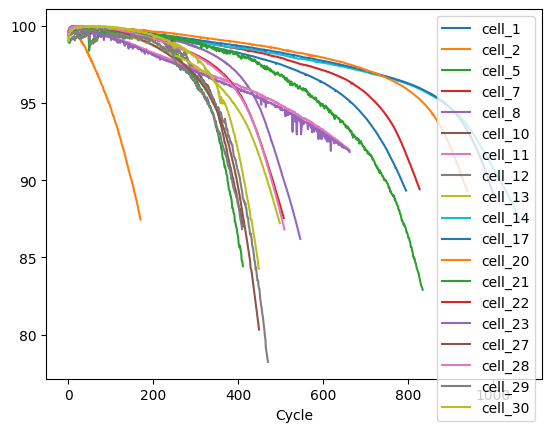

In [14]:
df_physical.iloc[:,:20].plot(x = 'Cycle')

In [15]:
def pad_sequences_to_length(sequences, target_length, pad_value=0):
    """
    Pad a list of sequences to a given target length.

    Args:
        sequences (list of Tensor): The list of tensor sequences.
        target_length (int): The fixed length to pad/truncate each sequence.
        pad_value (int): The value used for padding.

    Returns:
        Tensor: A tensor containing padded sequences with shape (batch_size, target_length).
    """
    # Create a new tensor to hold the padded sequences
    padded_sequences = torch.full((len(sequences), target_length), pad_value, dtype=sequences[0].dtype)

    # Iterate through each sequence and pad/truncate to the target length
    for i, seq in enumerate(sequences):
        end_idx = min(len(seq), target_length)
        padded_sequences[i, :end_idx] = seq[:end_idx]

    return padded_sequences

In [16]:
physical_cols = list(df_physical.columns[1:])

In [17]:
physical_sequences = torch.Tensor(df_physical.iloc[:,1:].values.T)

In [18]:
target_length = PHYSICAL_SEQ_LEN  # For example, pad all sequences to length 5

# Pad sequences
padded_sequences = pad_sequences_to_length(physical_sequences, target_length)

In [19]:
group_id_mapping = {k: df_operational.Battery.unique()[k] for k in range(0, df_operational.Battery.nunique())}

In [20]:
# Open and read the JSON file
with open('data/sev_gen_mapping.json', 'r') as file:
    mappings = json.load(file)

In [21]:
group_emb_map = {k: padded_sequences[physical_cols.index(mappings[group_id_mapping[k]])] for k in group_id_mapping.keys()}

In [22]:
tensor_list = [group_emb_map[i] for i in sorted(group_emb_map)]

## Load Weights

In [23]:
model = ACCEPT(embed_dim=100, training_operational = training_op)

/Users/jamessadler/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/jamessadler/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [24]:
state_dict = torch.load('accept/weights/weights.pth', map_location=torch.device('cpu'))

In [25]:
model.load_state_dict(state_dict)

<All keys matched successfully>

## Testing Data

In [26]:
test_df.head()

Battery  Cycle  v_d_mean  v_c_mean   v_d_std   v_c_std       dod  \
20868  b1c_0_10      1  2.723133  3.410184  0.506106  0.268454 -1.421978   
20869  b1c_0_10      2  2.730126  3.417162  0.504182  0.254523 -1.395634   
20870  b1c_0_10      3  2.733170  3.412501  0.502937  0.260055 -1.383670   
20871  b1c_0_10      4  2.734863  3.420053  0.503401  0.249591 -1.378289   
20872  b1c_0_10      5  2.736396  3.405882  0.504082  0.271837 -1.373971   

       cur_d_mean  cur_c_mean  cur_d_std  ...   T_c_std    T_d_min    T_c_min  \
20868   -3.188874    2.338535   1.519398  ...  0.973579  30.828300  29.914324   
20869   -3.205540    2.349137   1.503446  ...  0.813991  30.429403  30.046880   
20870   -3.214302    2.364543   1.496002  ...  0.702400  30.182175  30.491040   
20871   -3.211908    2.358275   1.497503  ...  0.923536  30.451065  29.761333   
20872   -3.213997    2.352498   1.493993  ...  0.726197  30.171482  29.649578   

         T_d_max    T_c_max        QD         Type  Capacity      QD_  \
20868  34.201159  33.999775  1.108190  APR18650M1A       1.1  1.10819   
20869  33.029738  33.431090  1.109278  APR18650M1A       1.1  1.10819   
20870  34.004902  33.984958  1.110096  APR18650M1A       1.1  1.10819   
20871  33.932159  33.571255  1.109450  APR18650M1A       1.1  1.10819   
20872  34.044601  32.693182  1.110943  APR18650M1A       1.1  1.10819   

        QD_Target  
20868  100.000000  
20869  100.098223  
20870  100.171983  
20871  100.113690  
20872  100.248432  

[5 rows x 24 columns]

In [27]:
testing_op = TimeSeriesDataSet(
    test_df,
    time_idx="Cycle",
    target="QD_Target",
    group_ids=["Battery"],
    static_categoricals = ['Type'],
    static_reals = ['Capacity'],
    min_encoder_length=min_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=df_operational.iloc[:, 2:-4].columns.to_list(),
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps = True
)

/Users/jamessadler/Library/Python/3.9/lib/python/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Battery': 'b1c_0_38'}]
  warnings.warn(


In [28]:
test_dataloader = testing_op.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [29]:
len(test_dataloader) # no. of batches

319

In [30]:
operational = next(iter(test_dataloader)) # First batch

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
operational = operational[0] # just need the features rather than the target
operational = {k: v.to(device) for k, v in operational.items()}
# Fetch real physically generated curves and append them to list
groups = operational['groups']
target_tensors_physical = torch.stack([tensor_list[i] for i in groups[:,0]])

target_tensors_physical = target_tensors_physical.unsqueeze(2)
target_tensors_physical = target_tensors_physical.to(device)

In [33]:
padded_sequences = padded_sequences.unsqueeze(2).to(device)

In [ ]:
# Compute Features
operational_features = model.encode_operational(operational)
physical_features = model.encode_physical(padded_sequences)
logit_scale = model.logit_scale.exp()

# Normalize features
operational_features = F.normalize(operational_features, dim=1)
physical_features = F.normalize(physical_features, dim=1)

# Cosine similarity (Image Features & Location Features)
logits_per_operational = logit_scale * (operational_features @ physical_features.t())

In [ ]:
logits_per_operational